In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import prototype
import torch

## Training : Simulations

We simulate a thermostat hyrbid system with initial temperature [20, 21, 22 ... 35]. This would be used as training data for our neural network

In [180]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/thermostat3.csv"))
training.head()

,time,initial_temp,temp,state
0,0,20,20.000,0
1,1,20,18.000,1
2,2,20,21.200,0
3,3,20,19.080,0
4,4,20,17.172,1


In [181]:
len(training)

160016

We want to the simulation with initial temperature of 33.

In [182]:
initial = training[training["initial_temp"] == 20]

(0.0, 50.0)

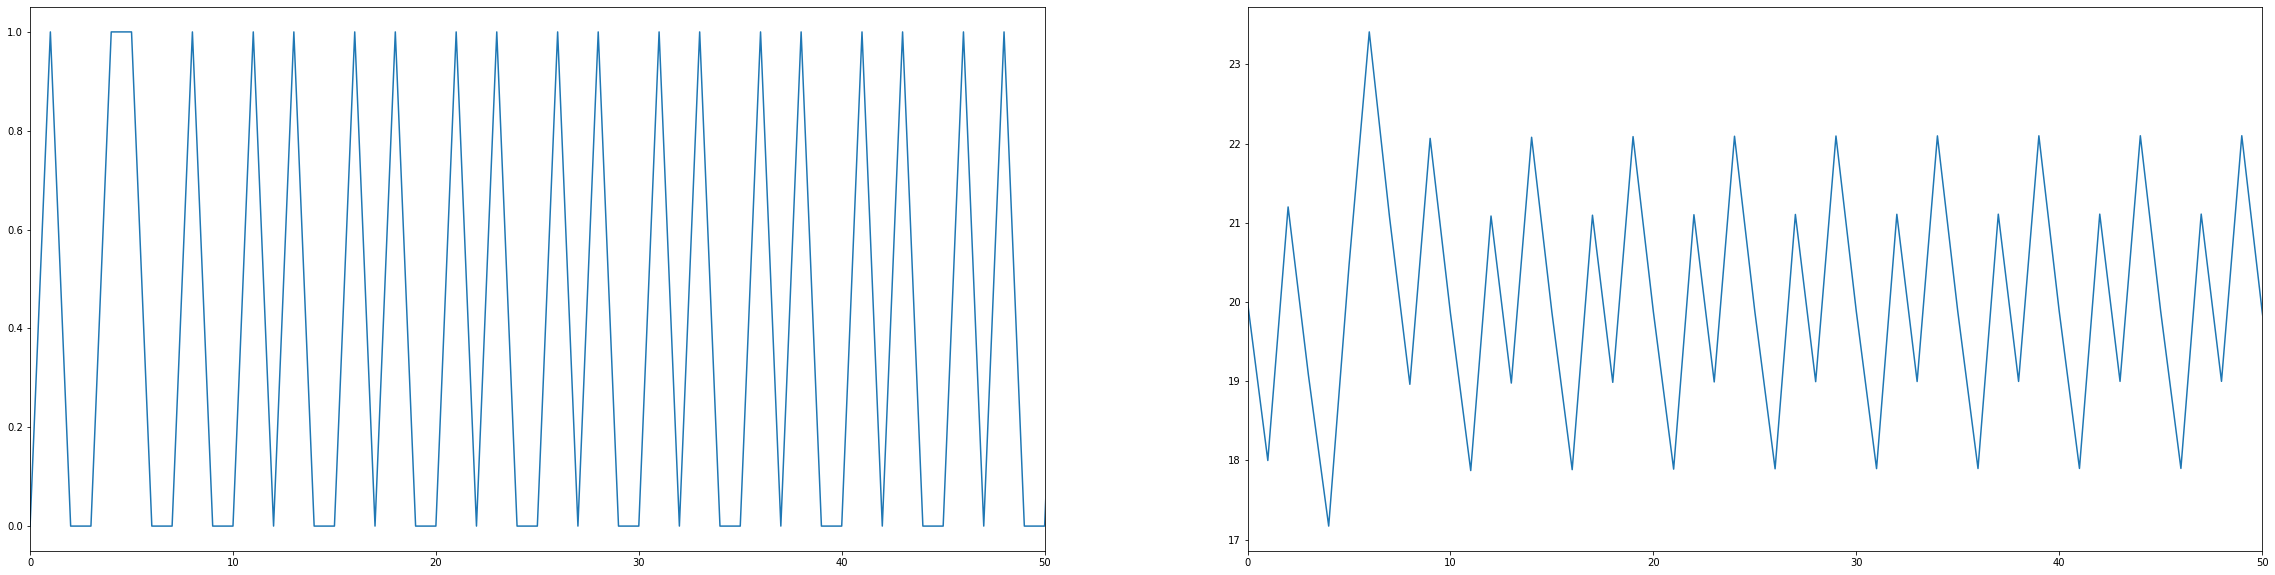

In [183]:
fig, ax = plt.subplots(ncols = 2, figsize=(40,10))
ax[0].plot(initial[["time"]], initial[["state"]])
ax[0].set_xlim([0,50])
ax[1].plot(initial[["time"]], initial[["temp"]])
ax[1].set_xlim([0,50])

This is cross validation being performed.

In [178]:
kfold = Splitting([0,1], [2], num_epoches = 30, batch_size = 128, lr= 0.00001)
#kfold = Splitting([0,1], [2], num_epoches = 10, batch_size = 8, lr= 0.0001)

In [179]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 28.95228385925293 
Epoch: 1  Train Loss: 12.097675323486328 
Epoch: 2  Train Loss: 10.791281700134277 
Epoch: 3  Train Loss: 15.025516510009766 
Epoch: 4  Train Loss: 7.64581823348999 
Epoch: 5  Train Loss: 4.419233322143555 
Epoch: 6  Train Loss: 8.613431930541992 
Epoch: 7  Train Loss: 11.424368858337402 
Epoch: 8  Train Loss: 8.737874031066895 
Epoch: 9  Train Loss: 12.96450424194336 
Epoch: 10  Train Loss: 11.707565307617188 
Epoch: 11  Train Loss: 9.442586898803711 
Epoch: 12  Train Loss: 6.67156982421875 
Epoch: 13  Train Loss: 7.755215167999268 
Epoch: 14  Train Loss: 16.736698150634766 
Epoch: 15  Train Loss: 8.551705360412598 
Epoch: 16  Train Loss: 9.339193344116211 
Epoch: 17  Train Loss: 9.082427024841309 
Epoch: 18  Train Loss: 12.549639701843262 
Epoch: 19  Train Loss: 5.526854038238525 
Epoch: 20  Train Loss: 14.786921501159668 
Epoch: 21  Train Loss: 10.875218391418457 
Epoch: 22  Train

We caclculate the average loss here

In [184]:
evaluate

[tensor(9.5853, grad_fn=<MseLossBackward>),
 tensor(9.2391, grad_fn=<MseLossBackward>),
 tensor(8.5011, grad_fn=<MseLossBackward>),
 tensor(10.0998, grad_fn=<MseLossBackward>),
 tensor(8.7466, grad_fn=<MseLossBackward>)]

In [185]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

9.234370040893555

## Training : Predictions

This is getting the predictions of simulation by the neural network

In [186]:
training_preds = pd.DataFrame(data = pd.read_csv("../../data/preds/train/thermostat.csv"))
training_preds.head()

,time,initial_temp,temp,state
0,0,20,18.107552,0
1,1,20,18.338680,1
2,2,20,18.537449,0
3,3,20,18.708435,0
4,4,20,18.855650,1


In [187]:
initial = training_preds[training_preds["initial_temp"] == 20]

(0.0, 20.0)

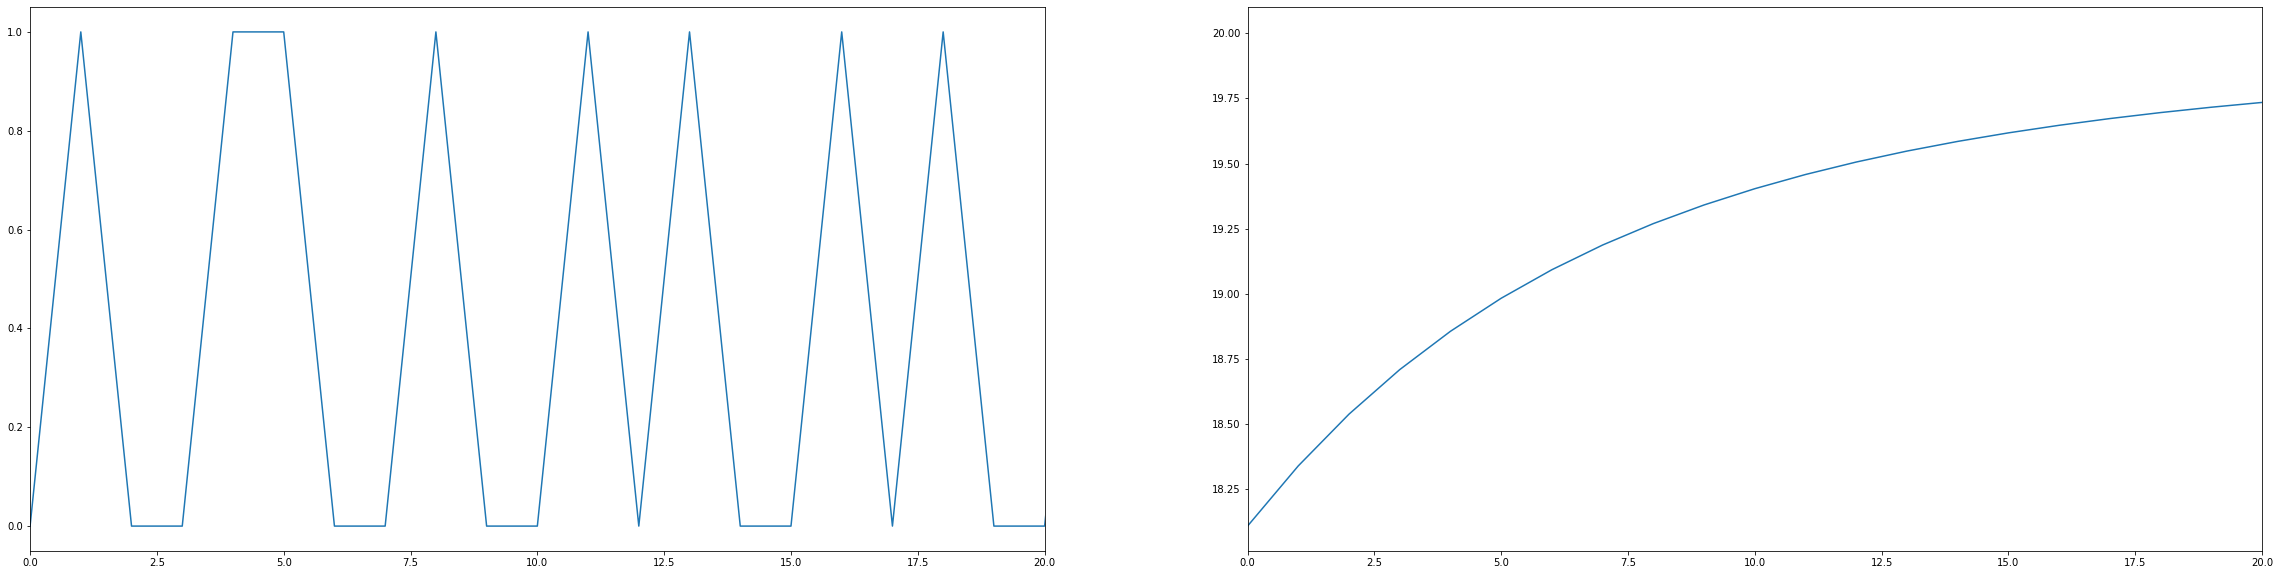

In [188]:
fig, ax = plt.subplots(ncols = 2, figsize=(40,10))
ax[0].plot(initial[["time"]], initial[["state"]])
ax[0].set_xlim([0,20])
ax[1].plot(initial[["time"]], initial[["temp"]])
ax[1].set_xlim([0,20])

This is manipulating the dataframes and creating a new dataframe therefore the training simulations and the prediction of the training data by the neural network can be within the same dataframe

In [189]:
training_preds = training_preds.rename(columns={
                                            'temp' : 'temp_preds'})
training_and_predictions = pd.merge(training, training_preds, right_on=["time", "initial_temp", "state"], left_on=["time", "initial_temp", "state"])

In [190]:
training_and_predictions.head()

,time,initial_temp,temp,state,temp_preds
0,0,20,20.000,0,18.107552
1,1,20,18.000,1,18.338680
2,2,20,21.200,0,18.537449
3,3,20,19.080,0,18.708435
4,4,20,17.172,1,18.855650


This function is used later for plotting the graphs

In [191]:
def hue(df, hue):
    for var in hue:
        columns = list(df.columns)
        columns.remove(var)
        columns.remove("{}_{}".format(var,"preds"))
        df = df.melt(columns, var_name=var, value_name = f"{var}_value")
    return df

In [192]:
def plot(x,y, **kwargs):
    plt.plot(x,y)
    plt.xlim([0,30])

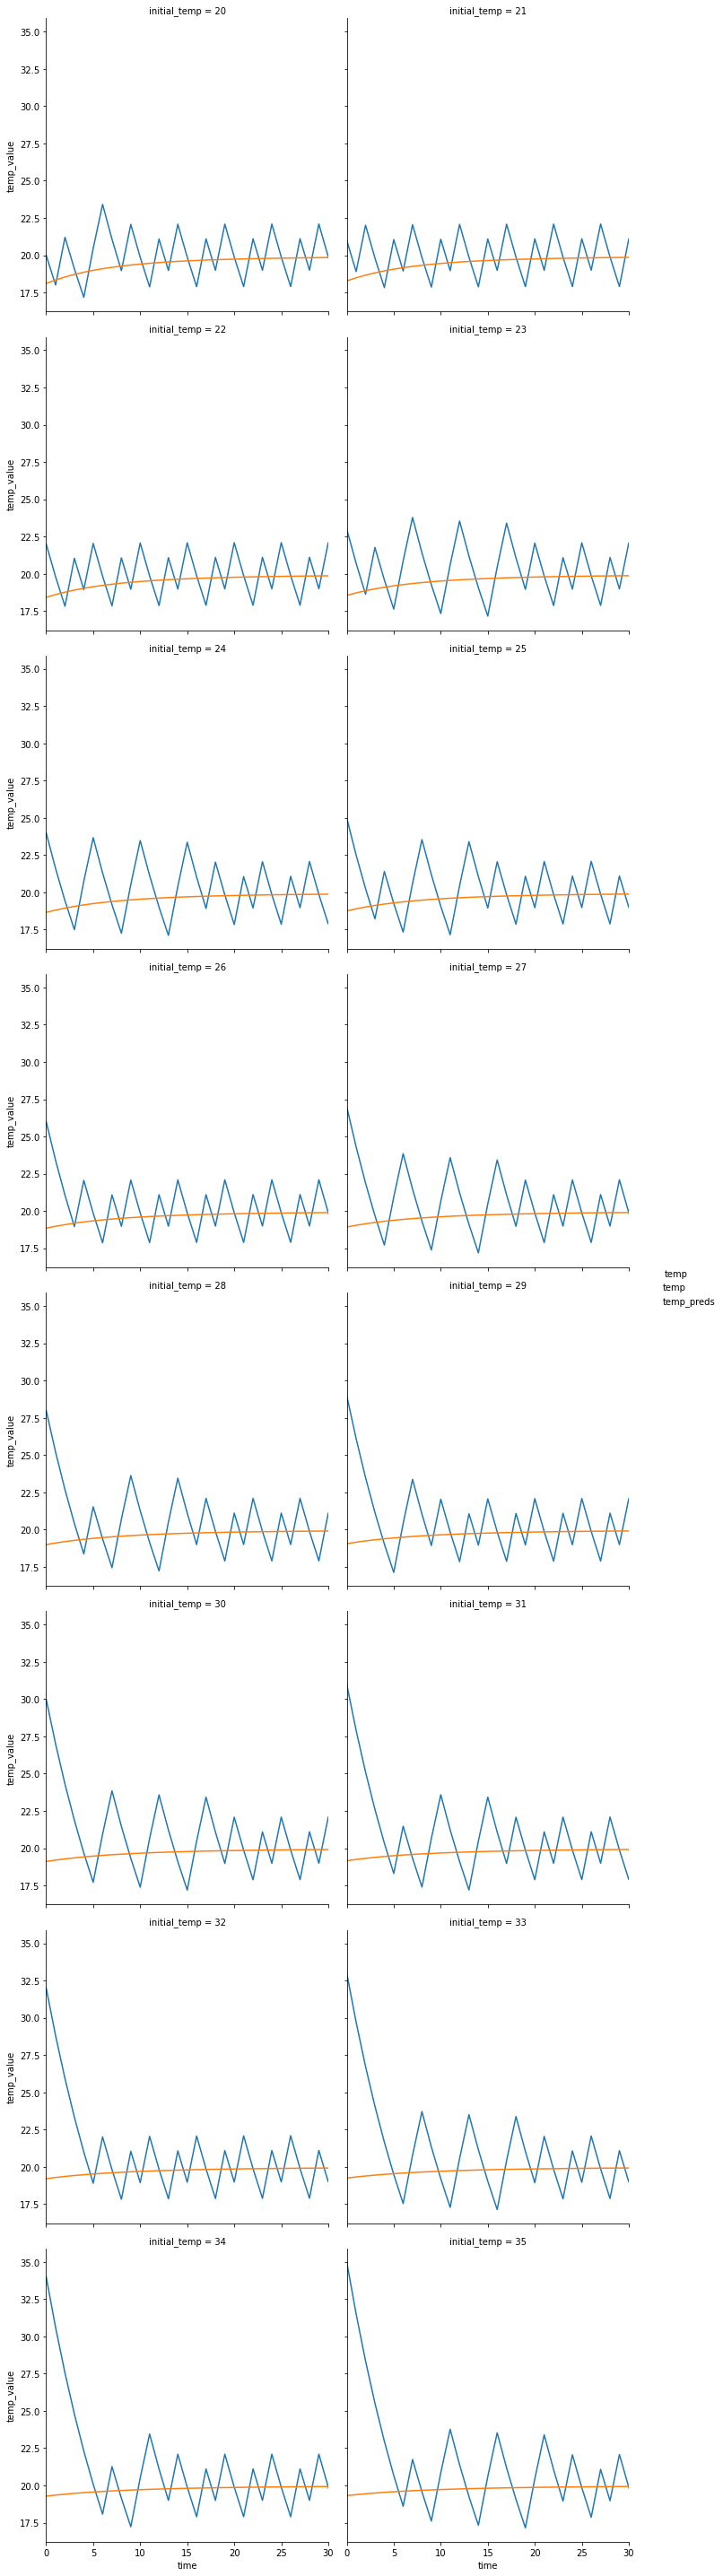

In [193]:
g = sns.FacetGrid(hue(training_and_predictions, ["temp"]), height = 5, col="initial_temp", hue="temp", col_wrap=2,)
g.map(plot, "time", "temp_value", ci=None)
g.add_legend()

## Testing : Simulation

In [28]:
testing = pd.DataFrame(data = pd.read_csv("../../data/test/thermostat.csv"))
testing.head()

,time,initial_temp,temp,state
0,0.0,36,36.000000,0
1,0.1,36,35.640000,0
2,0.2,36,35.283600,0
3,0.3,36,34.930764,0
4,0.4,36,34.581456,0


## Testing : Predictions

In [32]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,1,2]].values)
    targets = torch.tensor(test_df.iloc[:, [1,2]].values)
    preds, _ = predictions(num_inputs=3, num_classes=2, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/van.pth")
    data = {'time' : test_df.time.values,
            'initial_temp' : test_df.initial_temp.values,
            'temp' : tensor_flatten(preds[:,0]), 'state' : test_df.state.values}
    return pd.DataFrame(data = data, columns = ["time", "initial_temp", "temp","state"]);

In [33]:
testing_preds = testing_preds(testing)

In [34]:
testing_preds.head()

,time,initial_temp,temp,state
0,0.0,36,36.232121,0
1,0.1,36,36.125599,0
2,0.2,36,36.009895,0
3,0.3,36,35.898304,0
4,0.4,36,35.807007,0


In [35]:
testing_preds = testing_preds.rename(columns={
                                            'temp' : 'temp_preds'})
testing_and_predictions = pd.merge(testing, testing_preds, right_on=["time", "initial_temp", "state"], left_on=["time", "initial_temp", "state"])

In [36]:
testing_and_predictions.head()

,time,initial_temp,temp,state,temp_preds
0,0.0,36,36.000000,0,36.232121
1,0.1,36,35.640000,0,36.125599
2,0.2,36,35.283600,0,36.009895
3,0.3,36,34.930764,0,35.898304
4,0.4,36,34.581456,0,35.807007


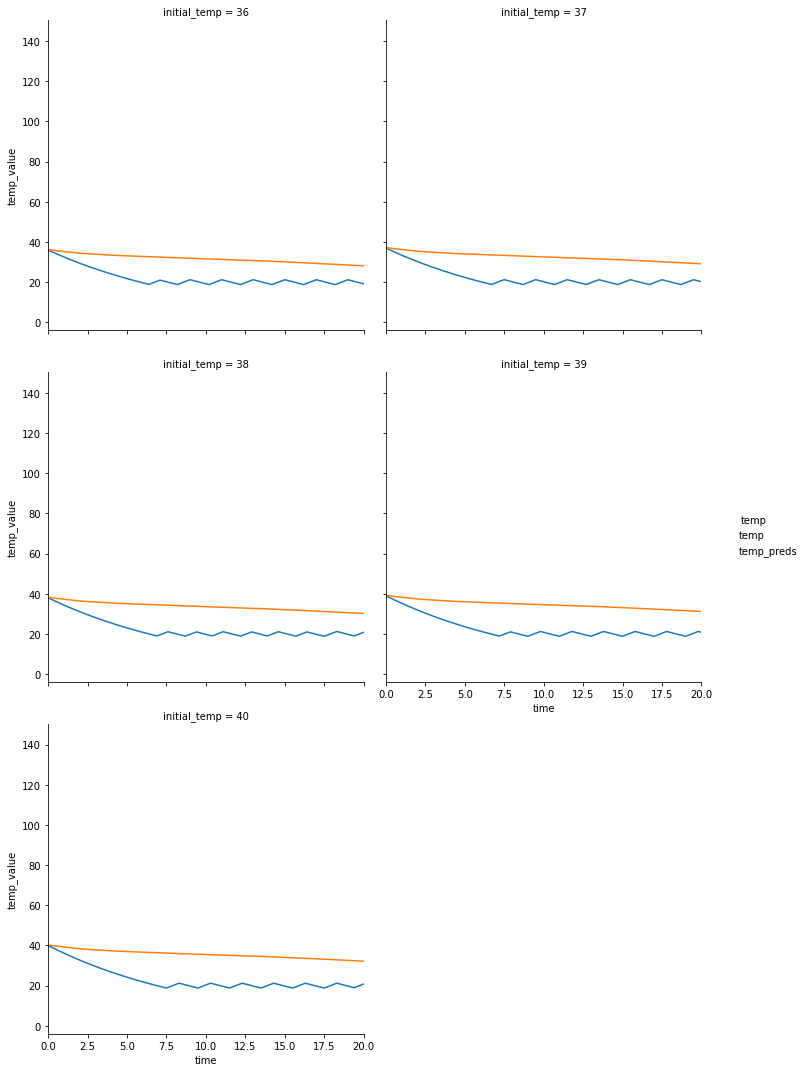

In [37]:
g = sns.FacetGrid(hue(testing_and_predictions, ["temp"]), height = 5, col="initial_temp", hue="temp", col_wrap=2,)
g.map(plot, "time", "temp_value", ci=None)
g.add_legend()